<a href="https://colab.research.google.com/github/RaquelGrosman/BigD/blob/master/2.0_WEEK2_INT_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
233964642  9.5498  9.071 36.4987501368371 -63.6475472217311    STAR
631352587 19.0099    nan 36.5158106667921  -63.652646940298    STAR
233964640 16.2948 15.759   36.51484678077  -63.640178739427    STAR
631352798 18.2615    nan 36.4801614858375 -63.6359185029504    STAR
631352990 18.4288    nan 36.5315849393531 -63.6497247654195    STAR
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-3-4      1      3   4
tess-s0002-3-3      2      3   3
tess-s0003-3-3      3      3   3
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   
Filename: <class '_io.BytesIO'>
No.    

Text(0.5, 1.0, 'Periodogram')

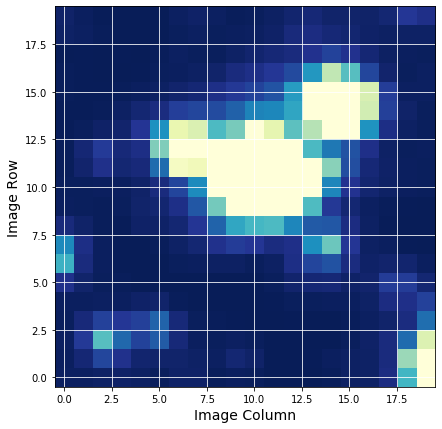

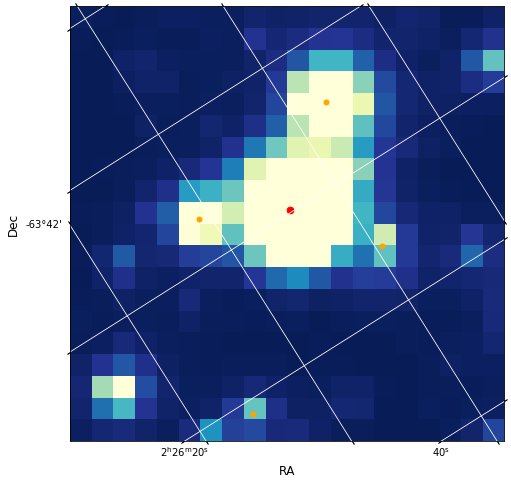

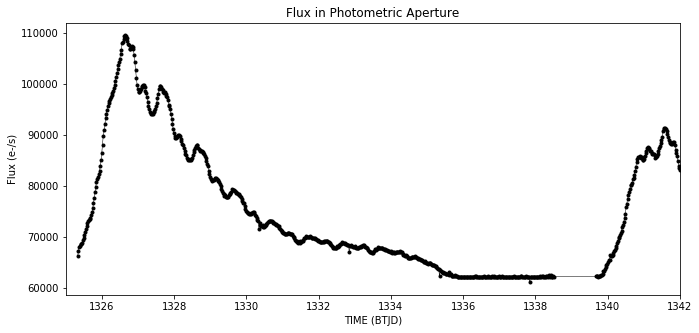

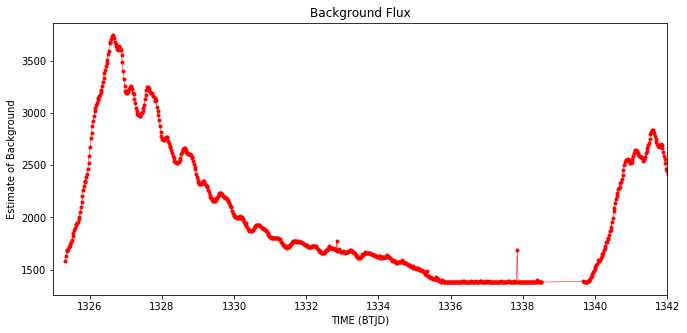

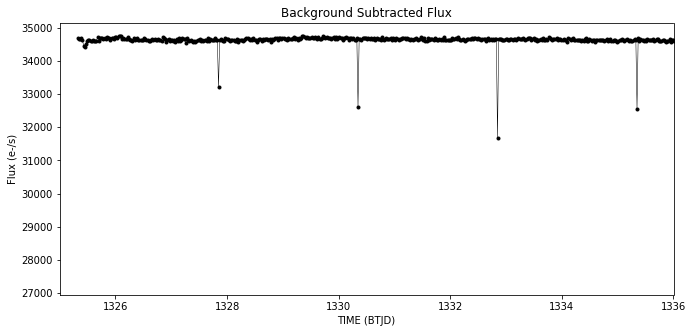

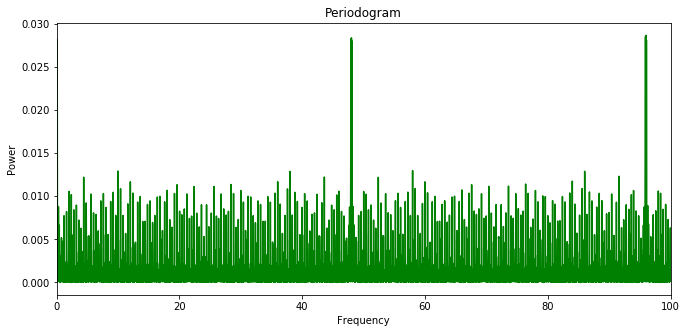

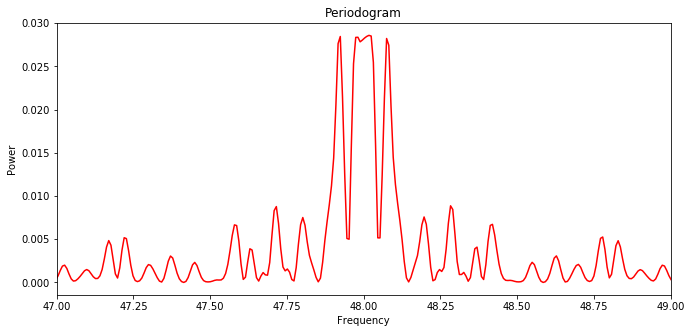

In [3]:
!pip install astroquery                          #ability to call differnt database: specifically Astroquery
import numpy as np                               #importung library so numpy array function can be called  
import matplotlib.pyplot as plt
from astroquery.mast import Catalogs             #impoting methods from astroquery
from astroquery.mast import Tesscut              #impoting methods from astroquery
from astropy.coordinates import SkyCoord         #impoting methods from astroquery
from astropy.wcs import WCS                      #impoting methods from astroquery
from astropy.io import fits                      #impoting methods from astroquery
from astropy.timeseries import LombScargle 

%matplotlib inline

ticid = 233964642    #highly important  the name of the start we want analyze ; chose an object

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

hdulist = Tesscut.get_cutouts(coord, 20)

hdulist[0].info()
hdulist[0][0].header['SECTOR']

hdulist[1].info()



# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')


hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)


hdu2 = hdulist[1]

firstImage = hdu2[1].data['FLUX'][0] #changed from 2 to 1

wcs = WCS(hdu2[2].header) #changed from 2 to 1

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')


def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux

 # Use all pixels in our aperture.
aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)
plt.xlim(1325,1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')


# Plot the flux change of the dimmest pixels by using percentile.
bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

plt.xlim(1325, 1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

plt.xlim(1325, 1336)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')

#periodgram
frequency, power = LombScargle(time1, bkgSubFlux).autopower(maximum_frequency=100)

plt.figure(figsize=(11, 5))
plt.plot(frequency, power, 'g')

plt.xlim(0, 100)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Periodogram')

#zoomed in periodgram 
frequency, power = LombScargle(time1, bkgSubFlux).autopower(maximum_frequency=49)

plt.figure(figsize=(11, 5))
plt.plot(frequency, power, 'r')

plt.xlim(47, 49)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Periodogram')

